<a href="https://colab.research.google.com/github/DonnaVakalis/Livability/blob/master/Gapminder2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: Which other metrics track the GINI coefficient, using data from Gapminder?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

**Questions posed:**
###1) Which countries have the highest/lowest average GINI coefficient (on average, for the last ten years)? 
###2) Which direction are GINI coefficients moving (for the last 50 years) worldwide?
###3) Within the U.S. how do the GINI coefficients compare at the state-level to the country as a whole?


**Datasets:** 

GINI world downloaded from https://www.gapminder.org/data/

USA downloaded from https://en.wikipedia.org/wiki/List_of_U.S._states_by_Gini_coefficient 


<a id='wrangling'></a>
## Data Wrangling


### LOAD DATA


In [1]:
# Install pycountry
!pip install pycountry

# Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab import drive
import pycountry
from functools import reduce #for merging dataframes
import plotly.express as px

# Settings
%matplotlib inline 
pd.options.display.float_format = '{:,.2f}'.format # display numbers with two decimal places

     |████████████████████████████████| 10.1MB 7.7MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746863 sha256=0686a916b7ce55bb6d01a26da6f151296ae401f233da851fc64eca7c26a9e9dc
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [2]:
# Mount Google Drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Load the data
base_dir = "/content/gdrive/My Drive/Colab Notebooks/project_gapminder/"

In [44]:

# GINI coefficients Global
file = base_dir + 'gini.csv' # from https://www.gapminder.org/data/
df_gini = pd.read_csv(file) # Read GINI --< CSV format

# GINI coefficients USA by State
file = base_dir + 'Gini_state_by_state.csv' # from https://en.wikipedia.org/wiki/List_of_U.S._states_by_Gini_coefficient
df_gini_USA = pd.read_csv(file) # Read States GINI --< CSV format

In [45]:
# types and look for shape, types and instances of missing or possibly errant data 
df_gini.head()
df_gini.info()
#df_gini
list_countries = df_gini['country'].unique().tolist()
len(list_countries)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Columns: 242 entries, country to 2040
dtypes: float64(241), object(1)
memory usage: 368.8+ KB


195

comments about df_gini:
- years range from 1800 to 2040 (which doesn't make any sense to me...)
- 195 countries
- this data set is full! i.e., no missing values for the countries and years given.
- notice many more years than other datasets explored from gapminder
- consider limiting scope of question to "last 20 years" + read more about how gini is calculated

In [46]:
# types and look for shape, types and instances of missing or possibly errant data in the States
df_gini_USA.head()
df_gini_USA.info()
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   52 non-null     object 
 1   GINI    52 non-null     float64
dtypes: float64(1), object(1)
memory usage: 960.0+ bytes



comments about df_gini_USA:

- years of data is 2010
- all 52 States present i.e., no missing values for the countries and years given.
- will need to add 3-letter State codes

 
### Data Cleaning
---
For Global Data: truncating to years of interest (1970-2020), Create column with average, Create column with delta for last 50 years, getting 3-letter country codes, Get the U.S. GINI from 2010

For U.S. Data: get 3-letter state codes, create a column with delta from country as a whole in 2010 (from Global data)

In [47]:
# Select "country" and years "1970" to "2020" within gini dataframe
cols_to_keep = np.r_[0, 171:222] #there are 242 columns beginning with 'country' then 1840...
df_g = df_gini.iloc[:,cols_to_keep]
df_g.head()

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Afghanistan,30.50,30.80,31.20,31.60,31.90,32.10,32.20,32.20,32.20,32.20,32.20,32.10,32.00,32.10,32.50,33.00,33.70,34.70,35.40,36.00,36.40,36.70,36.70,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80
1,Albania,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,27.00,27.00,27.00,27.00,27.00,27.20,27.50,28.00,28.60,29.40,30.20,30.70,31.00,31.10,31.00,30.70,30.40,30.20,30.00,29.70,29.50,29.30,29.10,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00
2,Algeria,39.90,39.90,39.90,40.00,40.00,40.00,40.00,40.00,40.00,40.10,40.10,40.10,40.10,40.10,40.10,40.10,40.20,40.00,39.80,39.40,38.80,38.10,37.40,36.70,36.10,35.50,34.90,34.40,34.00,33.50,33.10,32.60,32.20,31.70,31.20,30.80,30.30,29.90,29.40,29.00,28.50,28.20,27.90,27.70,27.60,27.60,27.60,27.60,27.60,27.60,27.60
3,Andorra,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00
4,Angola,54.80,54.70,54.60,54.50,54.40,54.40,54.30,54.20,54.10,54.00,53.90,53.80,53.70,53.60,53.50,53.40,53.30,53.20,53.10,53.00,52.90,52.80,52.80,52.70,52.60,52.50,52.40,52.30,52.20,52.10,51.80,51.30,50.60,49.70,48.50,47.30,46.20,45.00,44.10,43.40,42.90,42.70,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60


In [48]:
# Create new variables such as recent average and overall change

df_ = df_g.assign(
                    recent_mean = df_gini.iloc[:,-11:].mean(axis=1, numeric_only=True), # Create the average for last 10 years (2010-2020)
                    delta = df_gini['2020'] - df_gini['1970'] # Calculate the difference since 1970 (positive is increased)
)

In [28]:
# Get 3-letter country codes and make it column "iso_alpha"

# print(list_countries) # Uncomment to see list of countries
d_country_code = {}  # To hold the country names and their ISO
for country in list_countries:
    try:
        country_data = pycountry.countries.search_fuzzy(country)
        # country_data is a list of objects of class pycountry.db.Country
        # The first item  ie at index 0 of list is best fit
        # object of class Country have an alpha_3 attribute
        country_code = country_data[0].alpha_3
        d_country_code.update({country: country_code})
    except:
        print('could not add ISO 3 code for ->', country)
        # If could not find country, make ISO code ' '
        d_country_code.update({country: ' '})
        
 # create a new column iso_alpha in the df
# and fill it with appropriate iso 3 code
for k, v in d_country_code.items():
    df_.loc[(df_.country == k), 'iso_alpha'] = v

df_.head()


could not add ISO 3 code for -> Cape Verde
could not add ISO 3 code for -> Congo, Dem. Rep.
could not add ISO 3 code for -> Congo, Rep.
could not add ISO 3 code for -> Micronesia, Fed. Sts.
could not add ISO 3 code for -> North Korea
could not add ISO 3 code for -> South Korea
could not add ISO 3 code for -> St. Kitts and Nevis
could not add ISO 3 code for -> St. Lucia
could not add ISO 3 code for -> St. Vincent and the Grenadines
could not add ISO 3 code for -> Swaziland


,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,recent_mean,delta,iso_alpha
0,Afghanistan,30.50,30.80,31.20,31.60,31.90,32.10,32.20,32.20,32.20,32.20,32.20,32.10,32.00,32.10,32.50,33.00,33.70,34.70,35.40,36.00,36.40,36.70,36.70,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,36.80,6.30,AFG
1,Albania,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.80,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,26.90,27.00,27.00,27.00,27.00,27.00,27.20,27.50,28.00,28.60,29.40,30.20,30.70,31.00,31.10,31.00,30.70,30.40,30.20,30.00,29.70,29.50,29.30,29.10,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.00,29.08,2.20,ALB
2,Algeria,39.90,39.90,39.90,40.00,40.00,40.00,40.00,40.00,40.00,40.10,40.10,40.10,40.10,40.10,40.10,40.10,40.20,40.00,39.80,39.40,38.80,38.10,37.40,36.70,36.10,35.50,34.90,34.40,34.00,33.50,33.10,32.60,32.20,31.70,31.20,30.80,30.30,29.90,29.40,29.00,28.50,28.20,27.90,27.70,27.60,27.60,27.60,27.60,27.60,27.60,27.60,27.77,-12.30,DZA
3,Andorra,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,40.00,0.00,AND
4,Angola,54.80,54.70,54.60,54.50,54.40,54.40,54.30,54.20,54.10,54.00,53.90,53.80,53.70,53.60,53.50,53.40,53.30,53.20,53.10,53.00,52.90,52.80,52.80,52.70,52.60,52.50,52.40,52.30,52.20,52.10,51.80,51.30,50.60,49.70,48.50,47.30,46.20,45.00,44.10,43.40,42.90,42.70,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.60,42.64,-12.20,AGO


In [29]:
# we must manually add ISO 3 code for North Korea, South Korea, Swaziland, Congo, Dem. Rep. and Congo, Rep. ...
missing = {'North Korea':'PRK','South Korea':'KOR','Congo, Dem. Rep.':'COD','Congo, Rep.':'COG','Swaziland':'SWZ','Niger':'NER'}
for country_name,code in missing.items():
    df_.loc[(df_.country==country_name),'iso_alpha'] = code

df_[df_['country']=='Swaziland'].iso_alpha #check

df_[df_['country']=='Niger'].iso_alpha #check

124    NER
Name: iso_alpha, dtype: object

In [ ]:
# Convert the US data from wide to tall format

US_wide = df_gini.query('country=="United States"') 

# Convert long to tall dataframe
US_long= US_wide.melt(id_vars=["country"],
             var_name="year", # stack years vertically
             value_name='gini')  # insert the value for each year into new column

<a id='eda'></a>
## Exploratory Data Analysis

statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

### What does the GINI coefficient look like today over the globe?


In [30]:
df_.sort_values(by='recent_mean',ascending=True, inplace=True)
df_.head() #worst country is Ukraine (24.89, although it's been going up overall)
df_.tail() #best country is South Africa (63.10) 

,country,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,recent_mean,delta,iso_alpha
193,Zambia,68.20,68.30,68.50,68.70,68.80,69.00,69.20,69.40,69.60,69.50,69.20,68.70,67.90,66.90,65.80,64.80,63.80,62.80,61.70,61.10,59.80,58.00,56.10,54.10,51.70,50.10,49.40,48.70,48.00,47.40,46.30,44.90,45.00,46.60,48.50,50.70,53.30,54.70,55.00,55.30,55.60,55.90,56.20,56.50,56.80,57.00,57.10,57.10,57.10,57.10,57.10,56.68,-11.10,ZMB
118,Namibia,49.30,49.90,50.70,51.70,52.70,53.80,54.80,55.90,56.90,58.00,59.00,60.00,61.10,62.10,63.20,64.20,65.30,66.30,67.30,68.40,69.40,70.50,71.10,71.40,71.20,70.70,69.80,68.90,67.90,67.00,66.10,65.20,64.40,63.80,63.30,62.80,62.50,62.10,61.80,61.40,61.00,60.70,60.30,60.00,59.70,59.50,59.30,59.10,59.10,59.10,59.10,59.72,9.80,NAM
22,Botswana,53.80,53.80,53.90,53.90,53.90,53.90,54.00,54.00,54.00,54.00,54.10,54.10,54.10,54.10,54.20,54.40,54.70,55.20,55.90,56.70,57.50,58.30,59.10,59.90,60.60,61.20,61.70,62.10,62.50,63.00,63.40,63.90,64.10,64.10,63.90,63.50,62.90,62.30,61.70,61.20,60.80,60.60,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.50,60.54,6.70,BWA
166,Suriname,48.60,49.00,49.30,49.60,49.90,50.20,50.50,50.80,51.10,51.40,51.70,52.00,52.40,52.70,53.00,53.30,53.60,53.90,54.20,54.50,54.80,55.10,55.40,55.80,56.10,56.40,56.70,57.00,57.30,57.60,57.90,58.20,58.50,58.80,59.10,59.50,59.80,60.10,60.40,60.60,60.80,60.90,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,61.00,60.97,12.40,SUR
157,South Africa,68.50,68.40,68.20,67.90,67.60,67.30,67.00,66.70,66.40,66.10,65.80,65.40,65.00,64.60,64.20,63.80,63.40,63.00,62.60,62.10,61.60,60.90,60.40,60.10,60.00,60.00,60.10,59.90,59.50,58.90,58.80,59.20,60.00,61.30,62.60,63.40,63.90,63.90,63.60,63.40,63.30,63.20,63.20,63.20,63.10,63.10,63.00,63.00,63.00,63.00,63.00,63.10,-5.50,ZAF


In [31]:
fig = px.choropleth(df_, locations="iso_alpha",
                    color="recent_mean", # column for average last 10 years
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Greys)
fig.show()

This is a snapshot of the last 10 year average. The range of the coefficient is from low 20s to mid-60s. Without doing a 'real' test, at first glance it appears that richer countries have worse GINI coefficients, in general.  

### Which countries are going up versus down over the last 50 years?

In [32]:
fig = px.choropleth(df_, locations="iso_alpha",
                    color="delta", # column for difference
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.RdBu)
fig.show()

### Delve into one country: for U.S. what does it look like over time, and what are GINI coefficients at state level?

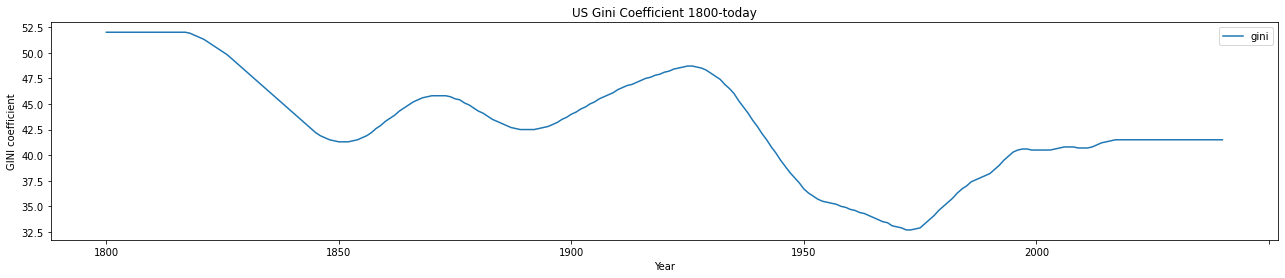

In [64]:
#Look at the US data from 1950 to today
timeline = pd.DataFrame(US_long,columns=['year','gini'])

timeline.plot(x ='year', y='gini', figsize=(22,4), kind = 'line')
 
plt.title('US Gini Coefficient 1800-today')
plt.xlabel('Year')
plt.ylabel('GINI coefficient')
plt.show()

In [68]:
# US Gini in 2010 Find the U.S. GINI coefficient in 2010
 
US_AVE = US_long.query('year=="2010"').gini

# Compare the individual states (over versus under)



210   40.70
Name: gini, dtype: float64

<a id='conclusions'></a>
## Conclusions

This is a snapshot of the last 10 year average. The range of the coefficient is from low 20s to mid-60s.  worst country is Ukraine (24.89, and it's been going down overall)
best country is South Africa (63.10) Without doing a 'real' test, at first glance it appears that richer countries have worse GINI coefficients, in general.

**Limitations:** The dataset is quite comprehensive, however there is some built-in ambiguity when interpreting the GINI coefficient. Based on what I've read here [https://www.investopedia.com/terms/g/gini-index.asp#:~:text=The%20Gini%20coefficient%20is%20equal,the%20line%20of%20perfect%20equality], the coefficient accuracy is dependent on reliable GDP and income data, and furthermore it obscures information about the "shape" of inequality. 


## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])